<a href="https://colab.research.google.com/github/nmurillon/DeepLearningChallenge/blob/main/ZZ3-DL-GRAVEGEAL-MURILLON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports


In [38]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Ajouter les imports nécessaires
import os #Changer le répertoire courant pour les chemins des fichiers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

##Variables globales

In [2]:
num_epochs = 100
batch_size = 250

img_shape = (28,28,1)
img_size = img_shape[:2]

target_shape = (32,32,3) #MobileNetV2 ne prend pas d'images (28,28,1) en entrée
target_size = target_shape[:2]

num_classes = 5
stop_freeze = 4


##Données

In [3]:
#On monte le drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Copie du zip dans le stockage local de la vm
!cp /content/drive/MyDrive/DeepLearning/Data_Train_Valid.zip /content/sample_data/Data_Train_Valid.zip

In [6]:
#unzip
!mkdir /content/sample_data/DeepLearning
!unzip /content/sample_data/Data_Train_Valid.zip -d /content/sample_data/DeepLearning

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/sample_data/DeepLearning/images/rabbit/rabbit_124616.png  
  inflating: /content/sample_data/DeepLearning/__MACOSX/images/rabbit/._rabbit_124616.png  
  inflating: /content/sample_data/DeepLearning/images/rabbit/rabbit_076144.png  
  inflating: /content/sample_data/DeepLearning/__MACOSX/images/rabbit/._rabbit_076144.png  
  inflating: /content/sample_data/DeepLearning/images/rabbit/rabbit_061438.png  
  inflating: /content/sample_data/DeepLearning/__MACOSX/images/rabbit/._rabbit_061438.png  
  inflating: /content/sample_data/DeepLearning/images/rabbit/rabbit_009790.png  
  inflating: /content/sample_data/DeepLearning/__MACOSX/images/rabbit/._rabbit_009790.png  
  inflating: /content/sample_data/DeepLearning/images/rabbit/rabbit_041930.png  
  inflating: /content/sample_data/DeepLearning/__MACOSX/images/rabbit/._rabbit_041930.png  
  inflating: /content/sample_data/DeepLearning/images/rab

In [4]:
#on change le répertoire courant pour faciliter l'accès aux données
os.chdir('/content/sample_data/DeepLearning') 

In [5]:
classes = ["basket","eye","binoculars","rabbit","hand"]

train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

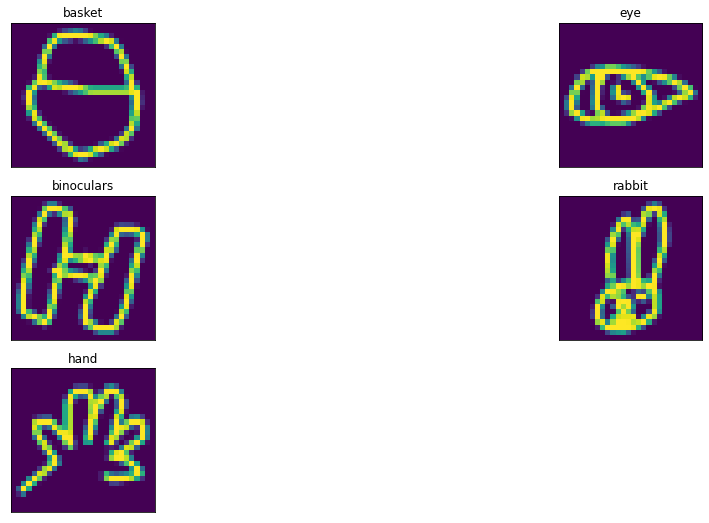

In [6]:
plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv("train.csv",skiprows = [1], nrows=1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im)
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    


In [7]:
def Data(target_size=target_size):
    x_train, x_test, y_train, y_test = [], [], [], []

    for img_path in train['relative_path']:
      x_train.append(np.array(Image.open('./images/' + img_path).resize(target_size).convert(mode="RGB")))
    x_train = np.array(x_train)

    for label in train['class_label']:
      y_train.append(label)
    y_train = np.array(y_train)

    for img_path in valid['relative_path']:
      x_test.append(np.array(Image.open('./images/' + img_path).resize(target_size).convert(mode="RGB")))
    x_test = np.array(x_test)

    for label in valid['class_label']:
      y_test.append(label)
    y_test = np.array(y_test)

    x_train = x_train.reshape(x_train.shape[0], target_size[0], target_size[0], 3)/255
    x_test = x_test.reshape(x_test.shape[0], target_size[0], target_size[0], 3)/255

    # # Conversion en matrices binaires
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    return ((x_train, y_train),(x_test, y_test))

In [25]:
from sklearn.utils import shuffle
def load_data_generator(x, y, batch_size=batch_size):
    num_samples = x.shape[0]
    while 1:  # Loop forever so the generator never terminates
        try:
            shuffle(x)
            for i in range(0, num_samples, batch_size):
                x_data = [im for im in x[i:i+batch_size]]
                y_data = y[i:i + batch_size]
            
                # convert to numpy array since this what keras required
                yield shuffle(np.array(x_data), np.array(y_data))
        except Exception as err:
            print(err)

##Modèle 1 : Fine tuning

Dans un premier temps, nous utiliserons le transfer Learning

In [39]:
def TransferModel(input_shape,stop_freeze, pretrained_model_constructor):
    '''
    @param model is a model from tensorflow.keras.applications
    '''

    pretrained_model = pretrained_model_constructor(weights="imagenet")
    pretrained_model_constructor(weights="imagenet", include_top = False, input_shape=input_shape, input_tensor=Input(input_shape)).summary()
    # On ôte la dernière couche de classification
    pretrained_model.layers.pop()   
    
    inputs = Input(input_shape)
    x = pretrained_model(inputs)
    
    # On fige tous les poids sauf ceux des stop_freeze dernières couches
    for i in range(len(pretrained_model.layers) - stop_freeze):
      pretrained_model.layers[i].trainable = False

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Sequential([
           pretrained_model_constructor(weights="imagenet", include_top = False, input_shape=input_shape, input_tensor=Input(input_shape)),
           Flatten(),
           Dense(num_classes, activation='softmax')     
    ])
    
    return model

##Entraînement du réseau

In [17]:
#Choix du modèle pré-entraîné
pretrained_model = tf.keras.applications.MobileNetV2
pretrained_model_name = "MobileNetV2"

In [10]:
#Chargement des données
(x_train, y_train) , (x_test, y_test) = Data()

In [40]:
#Construction du modèle

model = TransferModel(target_shape, stop_freeze, pretrained_model)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_35[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [41]:
# # Callback pour la sauvegarde du meilleur modèle
if not os.path.isdir("sauve"):
    os.mkdir("sauve")
    
checkpoint = ModelCheckpoint(f"sauve/{pretrained_model_name}" + "-loss-{val_loss:.2f}-acc-{accuracy:.2f}.h5",
                                save_best_only=True,verbose=1)

# # TODO !!!
# train_steps_epoch = np.ceil(x_train.samples / batch_size)
# val_steps_epoch = np.ceil(x_test.samples / batch_size)

# # Entraînement
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size,
                        epochs=num_epochs, verbose=1, callbacks=[checkpoint])

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.8976
Epoch 00001: val_loss improved from inf to 5.92666, saving model to sauve/MobileNetV2-loss-5.93-acc-0.90.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


300/300 [==============================] - 51s 120ms/step - loss: 0.3167 - accuracy: 0.8976 - val_loss: 5.9267 - val_accuracy: 0.5096
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9468
Epoch 00002: val_loss improved from 5.92666 to 4.08470, saving model to sauve/MobileNetV2-loss-4.08-acc-0.95.h5
300/300 [==============================] - 35s 116ms/step - loss: 0.1591 - accuracy: 0.9468 - val_loss: 4.0847 - val_accuracy: 0.5286
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9563
Epoch 00003: val_loss improved from 4.08470 to 2.60711, saving model to sauve/MobileNetV2-loss-2.61-acc-0.96.h5
300/300 [==============================] - 40s 132ms/step - loss: 0.1306 - accuracy: 0.9563 - val_loss: 2.6071 - val_accuracy: 0.6281
Epoch 4/100
300/300 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9597
Epoch 00004: val_loss improved from 2.60711 to 0.76051, saving model to sauve/Mobil

In [42]:
!cp -R /content/sample_data/DeepLearning/sauve /content/drive/MyDrive/DeepLearning/

In [47]:
#Construction du meilleur modèle
model = TransferModel(target_shape,stop_freeze, pretrained_model )
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.load_weights("sauve/MobileNetV2-loss-0.31-acc-1.00.h5") # TODO

# Evaluation du modèle
evaluation = model.evaluate(x_test, y_test, verbose=1)
print("Perte = {0:5.3f}, Précision = {1:5.3f}".format(evaluation[0], evaluation[1]))

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_43[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [48]:
# Quelques exemples de bonne / mauvaise classification
image_batch, label_batch = next(iter(x_test))

label_batch = [classes[np.argmax(label_batch[i])] for i in range(batch_size)]
predicted_classes = model.predict(image_batch)

predicted_ids = [np.argmax(predicted_classes[i]) for i in range(batch_size)]
predicted_classes = np.array([classes[id] for id in predicted_ids])

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_classes[n] == label_batch[n]:
        color = "blue"
        title = predicted_classes[n].title()
    else:
        color = "red"
        title = f"{predicted_classes[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Prédiction (bleu : OK, rouge : KO)")
plt.tight_layout()
plt.savefig("res.png",dpi=100)

ValueError: ignored